In [314]:
import pandas as pd
from pathlib import Path
import json
import requests
import numpy as np
import time
from  matplotlib import pyplot as plt

In [315]:
# setting paths to input files directory(source data used as input to this code) & output files directory(data created by this code)
input_files_path = Path("../input_files")
output_file_path = Path("../output_files")

#selecting hate-crime file to read from input file directory
input_file1 = "hate_crime.csv"
file_to_open = input_files_path / input_file1

# reading input file to a DataFrame
df = pd.read_csv(file_to_open, low_memory = False)
df.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,PUB_AGENCY_UNIT,AGENCY_TYPE_NAME,STATE_ABBR,STATE_NAME,DIVISION_NAME,REGION_NAME,...,OFFENDER_RACE,OFFENDER_ETHNICITY,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS
0,3015,1991,AR0040200,Rogers,NaN,City,AR,Arkansas,West South Central,South,...,White,NaN,1,Intimidation,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S
1,3016,1991,AR0290100,Hope,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S
2,43,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Residence/Home,Anti-Black or African American,Individual,S,S
3,44,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,2,Aggravated Assault;Destruction/Damage/Vandalis...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,M,S
4,3017,1991,AR0350100,Pine Bluff,NaN,City,AR,Arkansas,West South Central,South,...,Black or African American,NaN,1,Aggravated Assault,1.0,Service/Gas Station,Anti-White,Individual,S,S


In [316]:
#Data Cleaning
# deleting data before 2008 and reset index
df = df.loc[df['DATA_YEAR']>=2008, :]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65269 entries, 0 to 65268
Data columns (total 28 columns):
INCIDENT_ID                 65269 non-null int64
DATA_YEAR                   65269 non-null int64
ORI                         65269 non-null object
PUB_AGENCY_NAME             65269 non-null object
PUB_AGENCY_UNIT             1756 non-null object
AGENCY_TYPE_NAME            65269 non-null object
STATE_ABBR                  65269 non-null object
STATE_NAME                  65269 non-null object
DIVISION_NAME               65269 non-null object
REGION_NAME                 65269 non-null object
POPULATION_GROUP_CODE       65269 non-null object
POPULATION_GROUP_DESC       65269 non-null object
INCIDENT_DATE               65269 non-null object
ADULT_VICTIM_COUNT          29914 non-null float64
JUVENILE_VICTIM_COUNT       29812 non-null float64
TOTAL_OFFENDER_COUNT        65269 non-null int64
ADULT_OFFENDER_COUNT        28704 non-null float64
JUVENILE_OFFENDER_COUNT     28702 non-null

## Dropping non- useful columns



'PUB_AGENCY_UNIT' (only populated in approx 2% records, not useful for our analysis)

'POPULATION_GROUP_CODE' (just a alphanumeric code assigned for categorical data in POPULATION_GROUP, another column)

'OFFENDER_ETHNICITY' (available for approx 15% records, not useful for our analysis)


In [317]:
# Data Cleaning
df.drop(['PUB_AGENCY_UNIT', 'POPULATION_GROUP_CODE','OFFENDER_ETHNICITY'], axis = 1, inplace = True)

# dropping 'STATE_NAME' (we already have a duplicate column as STATE_ABBR, in case wish to save as a dictionary use following code
#state_name_dict = dict(zip(df['STATE_ABBR'].tolist(), df['STATE_NAME'].tolist()))

df.drop('STATE_NAME', axis = 1, inplace = True)
df.ORI.nunique()

6136

### converting INCIDENT_DATE from string to date-time dtype, as might be needed for seasonal analysis
### also retaining only month under this column, year is already in 'DATA_YEAR' column


In [318]:
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'])
df['INCIDENT_MONTH'] = pd.DatetimeIndex(df['INCIDENT_DATE']).month
df['INCIDENT_MONTH'].unique()

array([ 5,  8, 10, 11,  7, 12,  4,  9,  2,  3,  1,  6], dtype=int64)

In [319]:
df.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_ABBR,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_DESC,INCIDENT_DATE,...,OFFENDER_RACE,VICTIM_COUNT,OFFENSE_NAME,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS,INCIDENT_MONTH
0,133768,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-05-05,...,Black or African American,1,Destruction/Damage/Vandalism of Property,1.0,Residence/Home,Anti-Gay (Male),Individual,S,S,5
1,133769,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-05-31,...,Unknown,1,Destruction/Damage/Vandalism of Property,1.0,Residence/Home,Anti-Black or African American,Individual,S,S,5
2,133770,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-08-11,...,Multiple,1,Simple Assault,2.0,Service/Gas Station,"Anti-Multiple Races, Group",Individual,S,S,8
3,133771,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-10-09,...,White,1,Aggravated Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S,10
4,133772,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-11-08,...,Black or African American,1,Simple Assault,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S,11


In [320]:
df.columns

Index(['INCIDENT_ID', 'DATA_YEAR', 'ORI', 'PUB_AGENCY_NAME',
       'AGENCY_TYPE_NAME', 'STATE_ABBR', 'DIVISION_NAME', 'REGION_NAME',
       'POPULATION_GROUP_DESC', 'INCIDENT_DATE', 'ADULT_VICTIM_COUNT',
       'JUVENILE_VICTIM_COUNT', 'TOTAL_OFFENDER_COUNT', 'ADULT_OFFENDER_COUNT',
       'JUVENILE_OFFENDER_COUNT', 'OFFENDER_RACE', 'VICTIM_COUNT',
       'OFFENSE_NAME', 'TOTAL_INDIVIDUAL_VICTIMS', 'LOCATION_NAME',
       'BIAS_DESC', 'VICTIM_TYPES', 'MULTIPLE_OFFENSE', 'MULTIPLE_BIAS',
       'INCIDENT_MONTH'],
      dtype='object')

In [321]:
# Data Cleaning

# 'BIAS_DESC' contains multiple biases(upto 3) separated by ';', hence separating into 3 separate columns
# first creating a temporaty dataframe by splitting the 'BIAS_DESC' column
df_temp= df["BIAS_DESC"].str.split(";", n = 2, expand = True) 
  
# assigning split columns to our main dataframe
# we can delete column 'BIAS_DESC' now (presently retaining it)
df['BIAS_1'] = df_temp[0] 
df['BIAS_2'] = df_temp[1] 
df['BIAS_3'] = df_temp[2] 
df.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_ABBR,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_DESC,INCIDENT_DATE,...,TOTAL_INDIVIDUAL_VICTIMS,LOCATION_NAME,BIAS_DESC,VICTIM_TYPES,MULTIPLE_OFFENSE,MULTIPLE_BIAS,INCIDENT_MONTH,BIAS_1,BIAS_2,BIAS_3
0,133768,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-05-05,...,1.0,Residence/Home,Anti-Gay (Male),Individual,S,S,5,Anti-Gay (Male),None,None
1,133769,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-05-31,...,1.0,Residence/Home,Anti-Black or African American,Individual,S,S,5,Anti-Black or African American,None,None
2,133770,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-08-11,...,2.0,Service/Gas Station,"Anti-Multiple Races, Group",Individual,S,S,8,"Anti-Multiple Races, Group",None,None
3,133771,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-10-09,...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-Black or African American,Individual,S,S,10,Anti-Black or African American,None,None
4,133772,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-11-08,...,1.0,Highway/Road/Alley/Street/Sidewalk,Anti-White,Individual,S,S,11,Anti-White,None,None


In [322]:
# Data Cleaning

# 'LOCATION_NAME' contains multiple categories(upto 4) separated by ';', hence separating into 4 separate columns
# first creating a temporaty dataframe by splitting the 'LOCATION_NAME' column
df_temp= df["LOCATION_NAME"].str.split(";", n = 2, expand = True) 
  
# assigning split columns to our main dataframe

df['LOCATION_1'] = df_temp[0] 
df['LOCATION_2'] = df_temp[1] 
df['LOCATION_3'] = df_temp[2] 
 
df.LOCATION_NAME.nunique()

82

In [323]:
# df column 'LOCATION_NAME' contains upto 3 locations separated by ';', 
# we splitted this column into 3 new ones whiel creating 'df' initially. 

# however incidents containing multiple locations are only 85.., 
# so we will analyze basis the first mentioned location ('LOCATION_1')
df.LOCATION_2.count(), df.LOCATION_1.nunique()

(85, 46)

In [324]:
df.LOCATION_1.unique()

array(['Residence/Home', 'Service/Gas Station',
       'Highway/Road/Alley/Street/Sidewalk', 'Other/Unknown',
       'Hotel/Motel/Etc.', 'Church/Synagogue/Temple/Mosque',
       'Convenience Store', 'School/College',
       'Jail/Prison/Penitentiary/Corrections Facility', 'Field/Woods',
       'Department/Discount Store', 'Restaurant',
       'Parking/Drop Lot/Garage', 'Commercial/Office Building',
       'Grocery/Supermarket', 'Bar/Nightclub', 'Lake/Waterway/Beach',
       'Air/Bus/Train Terminal', 'Construction Site',
       'Government/Public Building',
       "Drug Store/Doctor's Office/Hospital", 'Specialty Store',
       'Bank/Savings and Loan', 'Liquor Store', 'Rental Storage Facility',
       'School-College/University', 'School-Elementary/Secondary',
       'Industrial Site', 'Shopping Mall',
       'Gambling Facility/Casino/Race Track', 'Camp/Campground',
       'Park/Playground', 'Tribal Lands',
       'Arena/Stadium/Fairgrounds/Coliseum', 'ATM Separate from Bank',
       'F

In [325]:
# Location Data Grouping

# create a new column to store Location buckets and initialize with LOCATION_1 values
df['LOCATION'] = df.LOCATION_1

# creating lists containing broad buckets of locations
educational_institutions = ['School/College','School-College/University','School-Elementary/Secondary' ]
utility_places = ['Service/Gas Station','Air/Bus/Train Terminal', 'Government/Public Building',
                   'ATM Separate from Bank','Bank/Savings and Loan',
                  'Daycare Facility', 'Auto Dealership New/Used', 'Dock/Wharf/Freight/Modal Terminal', 
                  'Community Center' 'Rental Storage Facility', "Drug Store/Doctor's Office/Hospital", 
                  'Hotel/Motel/Etc.'] 
recreation_places = ['Restaurant', 'Bar/Nightclub','Lake/Waterway/Beach','Gambling Facility/Casino/Race Track',
                    'Camp/Campground', 'Park/Playground', 'Arena/Stadium/Fairgrounds/Coliseum', 'Amusement Park'] 

shopping_places = ['Convenience Store', 'Department/Discount Store', 'Grocery/Supermarket','Specialty Store',
                   'Liquor Store', 'Shopping Mall' ]  
roads = ['Highway/Road/Alley/Street/Sidewalk']
religious_places = ['Church/Synagogue/Temple/Mosque']
residence = ['Residence/Home']
parking = ['Parking/Drop Lot/Garage']

#updating 'LOCATION' column with location categories
df['LOCATION'] = np.where(df['LOCATION_1'].isin(educational_institutions), 'Educational institution',' Others' )
df['LOCATION'] = np.where(df['LOCATION_1'].isin(utility_places), 'Public utility places', df['LOCATION'] )
df['LOCATION'] = np.where(df['LOCATION_1'].isin(recreation_places), 'Recreation places', df['LOCATION'] )
df['LOCATION'] = np.where(df['LOCATION_1'].isin(shopping_places), 'Shopping places', df['LOCATION'] )
df['LOCATION'] = np.where(df['LOCATION_1'].isin(roads), 'Highway/Road/Alley/Street/Sidewalk', df['LOCATION'] )
df['LOCATION'] = np.where(df['LOCATION_1'].isin(religious_places), 'Places of worship', df['LOCATION'] )
df['LOCATION'] = np.where(df['LOCATION_1'].isin(residence), 'Residence/Home', df['LOCATION'] )
df['LOCATION'] = np.where(df['LOCATION_1'].isin(parking), 'Parking/Drop Lot/Garage', df['LOCATION'] )
df.head()

,INCIDENT_ID,DATA_YEAR,ORI,PUB_AGENCY_NAME,AGENCY_TYPE_NAME,STATE_ABBR,DIVISION_NAME,REGION_NAME,POPULATION_GROUP_DESC,INCIDENT_DATE,...,MULTIPLE_OFFENSE,MULTIPLE_BIAS,INCIDENT_MONTH,BIAS_1,BIAS_2,BIAS_3,LOCATION_1,LOCATION_2,LOCATION_3,LOCATION
0,133768,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-05-05,...,S,S,5,Anti-Gay (Male),None,None,Residence/Home,None,None,Residence/Home
1,133769,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-05-31,...,S,S,5,Anti-Black or African American,None,None,Residence/Home,None,None,Residence/Home
2,133770,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-08-11,...,S,S,8,"Anti-Multiple Races, Group",None,None,Service/Gas Station,None,None,Public utility places
3,133771,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-10-09,...,S,S,10,Anti-Black or African American,None,None,Highway/Road/Alley/Street/Sidewalk,None,None,Highway/Road/Alley/Street/Sidewalk
4,133772,2008,AK0010100,Anchorage,City,AK,Pacific,West,"Cities from 250,000 thru 499,999",2008-11-08,...,S,S,11,Anti-White,None,None,Highway/Road/Alley/Street/Sidewalk,None,None,Highway/Road/Alley/Street/Sidewalk



  ## *<font color=red>Our Main Data Frame 'df' is now ready for use*</font>

In [326]:
df.shape

(65269, 32)

# importing data from FBI Crime website using API's

In [327]:
# importing api_key as saved in config.py file in same folder (Please type in your fbi api key in config.py file )
from config import api_key

## Query_URL :  base_url  + endpoint +? + api_key=".."

### base_url = "https://api.usa.gov/crime/fbi/sapi/"

### Many endpoints are offered by FBI but no endpoint offered for hate crimes category. hate-crime csv file contains data categorized by unique agency names.

### we have used below endpoints to get additional inputs for (1) year-wise / agency-wise total crime data (to compare hate-crime trend vs total crime trend), and (2) year-wise / agency-wise population covered (to determine crime rate as per 10,000 or per 100,000 residents). (3) year-wise state's total crime and population data 

#### /api/participation/agencies/{ori}
#### /api/summarized/agencies/{ori}/offenses/{since}/{until}
#### /api/estimates/states/{state}/{since}/{until}




In [328]:
base_url = "https://api.usa.gov/crime/fbi/sapi"

# making one sample call to check the json response structure
endpoint = f'/api/summarized/agencies/CA0010400/offenses/2007/2017'
response = requests.get(f"{base_url}{endpoint}?api_key={api_key}").json()
response.keys()

dict_keys(['results', 'pagination'])

In [329]:
# checking a sample record under 'results'
response['results'][0:2]

[{'ori': 'CA0010400',
  'data_year': 2007,
  'offense': 'aggravated-assault',
  'state_abbr': 'CA',
  'cleared': 17,
  'actual': 25},
 {'ori': 'CA0010400',
  'data_year': 2007,
  'offense': 'arson',
  'state_abbr': 'CA',
  'cleared': 0,
  'actual': 0}]

In [330]:
# making one sample call to check the json response structure
endpoint = f'/api/participation/agencies/CA0010400'
response = requests.get(f"{base_url}{endpoint}?api_key={api_key}").json()
response.keys()

dict_keys(['results', 'pagination'])

In [331]:
response['results'][0]

{'data_year': 2017,
 'state_id': 6,
 'state_abbr': 'CA',
 'ori': 'CA0010400',
 'population': 11971,
 'active': True,
 'published': True,
 'covered': False,
 'nibrs_submitting': False,
 'nibrs_start_date': None,
 'leoka_submitting': False,
 'leoka_start_date': None,
 'pe_reported_flag': True,
 'srs_submitting': True,
 'asr_submitting': True,
 'hc_submitting': True}

In [332]:
# making a list of all agencies as appearing in our hate-crime daraframe 
ori_list = df.ORI.unique().tolist()
len(ori_list) 

6136

## API CALL-1

## Below code will take more than 6 hours to run (and API server may sometime throw errors of rate limits) . 
## Results of below execution is saved in a csv file and used for analysis

In [250]:
# #below code collects agency-wise/year-wise population data through API calls, and stores results in a dictionary structure
# #finally converted to a dataframe 'df_population'

# # making a dictionary structure to collate the data colected in each API call.
# agency_population ={'ORI':[], 'DATA_YEAR':[], 'POPULATION':[]}

# # create an error_log list to store errors during API calls execution
# error_log = []

# #iterate over all agency names in hate-crime data and make API call for each agency
# for ori in ori_list:
        
#     endpoint =f'/api/participation/agencies/{ori}'
#     response = requests.get(f"{base_url}{endpoint}?api_key={api_key}").json()
#     api_call_count +=1
#     try:
        
#         # collecting data for 10 years period only (top -10 records in each json response)
#         for i in range(10):
#             agency_population['ORI'].append(response['results'][i]['ori'])
#             agency_population['DATA_YEAR'].append(response['results'][i]['data_year'])
#             agency_population['POPULATION'].append(response['results'][i]['population'])
            
#         success_count += 1
#         if success_count%50 == 0:
#             print (f"..{success_count} agencies so far..")
            
#     except:
        
#         error_log.append((ori,response))
                
#     # waiting for an hour after every 1000 API calls (enforcing rate lmit applicable for "api.data.gov")
#     if api_call_count%1000 == 0:
#         print("you have reached limit of 1000 API calls/hour..waiting for an hour before resuming the API calls ")
#         time.sleep(60*60)
        
# # convert dictionary to dataframe
# df_population = pd.DataFrame(agency_population)

..5850 agencies so far..
..5900 agencies so far..
..5950 agencies so far..
..6000 agencies so far..
..6050 agencies so far..


In [522]:
# # saving results to a csv file on disk. API call program code above takes 6 hours to execute and not repeatable everytime
# output_file1 = "agency_population_2008-2017.csv"
# file_to_write = output_file_path / output_file1
# df_population.to_csv(file_to_write, encoding='utf-8')
# len(df_population)

60870

In [333]:
#reading the dataframe from our csv file created in output directory (API call segment is not repeatable everytime as it takes 6 hours)
df_population = pd.read_csv(output_file_path / 'agency_population_2008-2017.csv')
# removing an unwanted column
df_population.drop('Unnamed: 0', axis = 1, inplace = True)
df_population.tail()

,ORI,DATA_YEAR,POPULATION
60865,WY0010200,2012,0
60866,WY0010200,2011,0
60867,WY0010200,2010,0
60868,WY0010200,2009,0
60869,WY0010200,2008,0


## API CALL -2

## Below code will take more than 6 hours to run (and API server may sometime throw errors of rate limits) . 
## Results of the execution is saved in a csv file and used for analysis

In [362]:
# #below code collects agency-wise/year-wise all crime data through API calls, and stores results in a dictionary structure
# #finally converted to a dataframe 'df_crime'

# # making a dictionary structure to collat the data colected in each API call.
# crime_all ={'ORI':[], 'DATA_YEAR':[], 'OFFENSE_NAME':[], 'STATE_ABBR':[], 'CLEARED':[], 'ACTUAL':[]}


# api_call_count = 0  # keeping track of API Calls to restrict to 1000 calls per hour (max as per 'api.data.gov' limits)

# # create an error_log list to store errors during API calls execution
# error_log = []

# #iterate over all agency names in hate-crime data and make API call for each agency
# for ori in new_list:
        
#     endpoint = f'/api/summarized/agencies/{ori}/offenses/2007/2017'
#     response = requests.get(f'{base_url}{endpoint}?api_key={api_key}').json()
#     api_call_count += 1
    
#     try:
        
#         for i in range(len(response['results'])):
#             crime_all['ORI'].append(response['results'][i]['ori'])
#             crime_all['DATA_YEAR'].append(response['results'][i]['data_year'])
#             crime_all['OFFENSE_NAME'].append(response['results'][i]['offense'])
#             crime_all['STATE_ABBR'].append(response['results'][i]['state_abbr'])
#             crime_all['CLEARED'].append(response['results'][i]['cleared'])
#             crime_all['ACTUAL'].append(response['results'][i]['actual'])
            
#     except:
#         error_log.append((ori, response))
#         print("error with", ori)
    
#     if api_call_count%1000 == 0:
#         print("you have reached limit of 1000 API calls/hour..waiting for an hour before resuming the API calls ")
#         time.sleep(60*60)
                    
# df_crime = pd.DataFrame(crime_all)

# df_crime.head()

error with CA0411000
error with CO0240100
error with CO0350100
error with KY0240200
error with ME016SP00
error with MI1375700
error with MI3852700
error with MI5061300
error with MI6367300
error with MI6571200
error with MI7420900
error with MO0210100
error with NJ0110900
error with UT0180100
error with WI0451300
error with CA0210400
error with KS0872300
error with ME006SP00
error with ME013SP00
error with MI3876900
error with MI4130000
error with MI5576300
error with ND0180200
error with NY0030600
error with OH0020300
error with OR0260500
error with CO0510300
error with GA0331100
error with ME001SP00
error with NY451PR0X
error with PA0220600
error with ME014SP00
error with CA0210800
error with MI1347600
error with MI5948100
error with MI7075600
error with MI7362900
error with TN0550300
error with MN0621200
error with MO0954100
error with PA0430100
error with CO0280100
error with ID0050100
error with ME004SP00
error with NV0161500
error with PA0153500
error with TX1081700
error with VT

,ORI,DATA_YEAR,OFFENSE_NAME,STATE_ABBR,CLEARED,ACTUAL
0,AK0010100,2007,aggravated-assault,AK,1155,1673
1,AK0010100,2007,arson,AK,29,145
2,AK0010100,2007,burglary,AK,222,1454
3,AK0010100,2007,homicide,AK,17,22
4,AK0010100,2007,human-trafficing,AK,0,0


In [26]:
# # saving results to a csv file on disk. API call program code above takes 6 hours to execute and not repeatable everytime
# output_file2 = "crime_data_2008-2017.csv"
# file_to_write = output_file_path / output_file2
# df_crime.to_csv(file_to_write, encoding='utf-8')

In [334]:
# reading this dataframe back from disk now
output_file2 = "crime_data_2008-2017.csv"
file_to_write = output_file_path / output_file2

df_crime = pd.read_csv(file_to_write)
# removing unwanted columns
df_crime.drop('Unnamed: 0', axis = 1, inplace = True)
df_crime.tail()

,ORI,DATA_YEAR,OFFENSE_NAME,STATE_ABBR,CLEARED,ACTUAL
806971,WY0170100,2017,property-crime,WY,106,357
806972,WY0170100,2017,rape,WY,0,0
806973,WY0170100,2017,rape-legacy,WY,0,0
806974,WY0170100,2017,robbery,WY,0,0
806975,WY0170100,2017,violent-crime,WY,8,8


### Above total crime and population data collected referes to the same agency/area where hate-crimes are committed.
### For doing a complete statewise analysis, let us also collect overall total crime and total population for each state and each year

## API CALL-3

In [335]:
# Sample API response
myurl = f"https://api.usa.gov/crime/fbi/sapi/api/estimates/states/CA/2007/2017?api_key={api_key}"
requests.get(myurl).json()['results'][0]

{'state_id': 6,
 'state_abbr': 'CA',
 'year': 2016,
 'population': 39296476,
 'violent_crime': 174796,
 'homicide': 1930,
 'rape_legacy': 13702,
 'rape_revised': 13702,
 'robbery': 54789,
 'aggravated_assault': 104375,
 'property_crime': 1002070,
 'burglary': 188304,
 'larceny': 637010,
 'motor_vehicle_theft': 176756,
 'arson': 7766}

In [336]:
#creating a list of states to iterate through FBI API's and collect year-wise population record of each state
state_list = df.STATE_ABBR.unique().tolist()
len(state_list) # include 51st entry as 'GM' for Guam in US territories (single record) we will ignore this

51

In [337]:
state_list[0:5]

['AK', 'AL', 'AR', 'AZ', 'CA']

In [338]:
# create a dictionary to hold total crime incidents & total population data
state_tot_crime_population_dict = {'STATE_ABBR':[], 'DATA_YEAR': [], 'STATE_POPULATION':[], 'STATE_TOTAL_CRIMES':[]}
state_tot_crime_population_dict

{'STATE_ABBR': [],
 'DATA_YEAR': [],
 'STATE_POPULATION': [],
 'STATE_TOTAL_CRIMES': []}

In [339]:
for state in state_list:
    if state == 'NB':
            state = 'NE'  # 'FBI API results contain 'NE' for Nebraska
    try:
        
        myurl = f"https://api.usa.gov/crime/fbi/sapi/api/estimates/states/{state}/2007/2017?api_key={api_key}"
        record = requests.get(myurl).json()
        for i in range (len(record['results'])):
            if state == 'NE':
                state_tot_crime_population_dict['STATE_ABBR'].append('NB')
            else:
                state_tot_crime_population_dict['STATE_ABBR'].append(record['results'][i]['state_abbr'])
            
            state_tot_crime_population_dict['DATA_YEAR'].append(record['results'][i]['year'])
            
            state_tot_crime_population_dict['STATE_POPULATION'].append(record['results'][i]['population'])
            
            crime1 = record['results'][i]['violent_crime']
            crime2 = record['results'][i]['property_crime']
            crime3 = record['results'][i]['burglary']
            crime4 = record['results'][i]['larceny']
            crime5 = record['results'][i]['motor_vehicle_theft']
            crime6 = record['results'][i]['arson']
            
            tot_crimes = ((crime1 if crime1 != None else 0)+(crime2 if crime2 != None else 0)+
                          (crime3 if crime3 != None else 0)+(crime4 if crime4 != None else 0)+
                          (crime5 if crime5 != None else 0)+(crime6 if crime6 != None else 0))
            
            state_tot_crime_population_dict['STATE_TOTAL_CRIMES'].append(tot_crimes)
            
            
    except:
        print (f'error in fethching  data of {state}')
        print (f'{record}')
                                            
df_state_tot_crime_population = pd.DataFrame(state_tot_crime_population_dict)
df_state_tot_crime_population.head()

,STATE_ABBR,DATA_YEAR,STATE_POPULATION,STATE_TOTAL_CRIMES
0,AK,1999,619500,50106
1,AK,2000,626932,49728
2,AK,2001,633630,50055
3,AK,2002,641482,51863
4,AK,2003,648280,52649


In [340]:
df_state_tot_crime_population.tail()

,STATE_ABBR,DATA_YEAR,STATE_POPULATION,STATE_TOTAL_CRIMES
1945,WY,1990,453588,36831
1946,WY,1991,460000,38951
1947,WY,1992,466000,41151
1948,WY,1993,470000,37787
1949,WY,1994,476000,39541


In [341]:
# saving results to a csv file on disk. API call program code above takes 6 hours to execute and not repeatable everytime
output_file3 = "total_crime_population_data_2008-2017.csv"
file_to_write = output_file_path / output_file3
df_state_tot_crime_population.to_csv(file_to_write, encoding='utf-8')

In [342]:
# reading this dataframe back from disk now
output_file3 = "total_crime_population_data_2008-2017.csv"
file_to_write = output_file_path / output_file3

df_state_tot_crime_population = pd.read_csv(file_to_write)
# removing unwanted columns
df_state_tot_crime_population.drop('Unnamed: 0', axis = 1, inplace = True)
df_state_tot_crime_population.tail()

,STATE_ABBR,DATA_YEAR,STATE_POPULATION,STATE_TOTAL_CRIMES
1945,WY,1990,453588,36831
1946,WY,1991,460000,38951
1947,WY,1992,466000,41151
1948,WY,1993,470000,37787
1949,WY,1994,476000,39541


## *<font color=red>dataframes 'df_crime', df_population & df_state_tot_crime_population are now ready for analysis*</font>

## Creating dataframe df_states from original dataframe and, merging additional data collected through API calls

In [343]:
df_states = df.pivot_table(index = ['STATE_ABBR', 'ORI', 'DATA_YEAR'], values = ['INCIDENT_ID'], aggfunc = np.size)


### Merging agencywise crime, population data into df_states

In [344]:
df_states.shape

(19311, 1)

In [345]:
df_crime.head()

,ORI,DATA_YEAR,OFFENSE_NAME,STATE_ABBR,CLEARED,ACTUAL
0,AK0010100,2007,aggravated-assault,AK,1155,1673
1,AK0010100,2007,arson,AK,29,145
2,AK0010100,2007,burglary,AK,222,1454
3,AK0010100,2007,homicide,AK,17,22
4,AK0010100,2007,human-trafficing,AK,0,0


In [346]:
df_crime.shape

(806976, 6)

In [347]:
#reshaping df_crime to merge with df_states
df_crime_reshape = df_crime.pivot_table(index = ['STATE_ABBR', 'ORI', 'DATA_YEAR'], values = ['ACTUAL'], aggfunc = np.sum)
df_crime_reshape.head()

ACTUAL
STATE_ABBR ORI       DATA_YEAR        
AK         AK0010100 2007        27169
                     2008        23822
                     2009        25719
                     2010        25378
                     2011        23812

In [348]:
df_crime_reshape.shape

(66412, 1)

In [349]:
#merging total crime incidents data to df_states
df_states = pd.merge(df_states, df_crime_reshape, how='left',left_index = True, right_index=True)
df_states.shape

(19311, 2)

In [350]:
df_states.head()

INCIDENT_ID   ACTUAL
STATE_ABBR ORI       DATA_YEAR                      
AK         AK0010100 2008                 6  23822.0
                     2009                 7  25719.0
                     2010                 7  25378.0
                     2011                 8  23812.0
                     2012                 6  26141.0

In [351]:
#resetting multiindex to columns for analysis
df_states.reset_index(inplace=True)
df_states.rename(columns={'INCIDENT_ID':'HATE_CRIMES', 'ACTUAL': 'TOTAL_CRIMES_SAME_AREA'}, inplace=True)
df_states.head()

,STATE_ABBR,ORI,DATA_YEAR,HATE_CRIMES,TOTAL_CRIMES_SAME_AREA
0,AK,AK0010100,2008,6,23822.0
1,AK,AK0010100,2009,7,25719.0
2,AK,AK0010100,2010,7,25378.0
3,AK,AK0010100,2011,8,23812.0
4,AK,AK0010100,2012,6,26141.0


In [352]:
# checking number of rows in merged dataframe to be same as in original df_states
df_states.shape

(19311, 5)

### merging agencywise population data

In [353]:
df_population.head()

,ORI,DATA_YEAR,POPULATION
0,AK0010100,2017,296188
1,AK0010100,2016,299097
2,AK0010100,2015,301239
3,AK0010100,2014,301306
4,AK0010100,2013,299455


In [354]:
#merging agency-wise population data also from df_population
df_states = pd.merge(df_states, df_population, on = ['ORI', 'DATA_YEAR'], how='left')

In [355]:
df_states.shape

(19525, 6)

In [356]:
#dropping duplicate values of rows, created in merged entity on account of duplicate records in df_population(restarting multiple API calls)
df_states.drop_duplicates(inplace=True)
df_states.shape

(19311, 6)

In [357]:
df_states.rename(columns={'POPULATION':'POPULATION_SAME_AREA'}, inplace=True)
df_states.head()

,STATE_ABBR,ORI,DATA_YEAR,HATE_CRIMES,TOTAL_CRIMES_SAME_AREA,POPULATION_SAME_AREA
0,AK,AK0010100,2008,6,23822.0,280068.0
1,AK,AK0010100,2009,7,25719.0,283300.0
2,AK,AK0010100,2010,7,25378.0,291826.0
3,AK,AK0010100,2011,8,23812.0,296955.0
4,AK,AK0010100,2012,6,26141.0,299143.0


In [358]:
df_states_final = df_states.pivot_table(index = ['STATE_ABBR','DATA_YEAR'], values = ['HATE_CRIMES', 'TOTAL_CRIMES_SAME_AREA', 'POPULATION_SAME_AREA'], aggfunc = np.sum)
df_states_final.head()

HATE_CRIMES  POPULATION_SAME_AREA  \
STATE_ABBR DATA_YEAR                                      
AK         2008                 8              286625.0   
           2009                 9              289884.0   
           2010                 7              291826.0   
           2011                 8              296955.0   
           2012                 6              299143.0   

                      TOTAL_CRIMES_SAME_AREA  
STATE_ABBR DATA_YEAR                          
AK         2008                      24112.0  
           2009                      26148.0  
           2010                      25378.0  
           2011                      23812.0  
           2012                      26141.0

In [359]:
df_states_final.shape

(499, 3)

In [360]:
# merging df_states with df_state_tot_crime_population
df_state_tot_crime_population_reshape = df_state_tot_crime_population.pivot_table(index = ['STATE_ABBR', 'DATA_YEAR'], values = ['STATE_POPULATION', 'STATE_TOTAL_CRIMES'], aggfunc = np.sum)
df_state_tot_crime_population_reshape.head()

STATE_POPULATION  STATE_TOTAL_CRIMES
STATE_ABBR DATA_YEAR                                      
AK         1979                 406000               48380
           1980                 440142               47779
           1981                 412000               51805
           1982                 438000               51690
           1983                 479000               54718

In [361]:
df_results = pd.merge(df_states_final, df_state_tot_crime_population_reshape, how='left',left_index = True, right_index=True)
df_results.head()

HATE_CRIMES  POPULATION_SAME_AREA  \
STATE_ABBR DATA_YEAR                                      
AK         2008                 8              286625.0   
           2009                 9              289884.0   
           2010                 7              291826.0   
           2011                 8              296955.0   
           2012                 6              299143.0   

                      TOTAL_CRIMES_SAME_AREA  STATE_POPULATION  \
STATE_ABBR DATA_YEAR                                             
AK         2008                      24112.0          686293.0   
           2009                      26148.0          698473.0   
           2010                      25378.0          714146.0   
           2011                      23812.0          723860.0   
           2012                      26141.0          730307.0   

                      STATE_TOTAL_CRIMES  
STATE_ABBR DATA_YEAR                      
AK         2008                  44822.0  
           2009                  45690.0  
           2010                  45233.0  
           2011                  42826.0  
           2012                  44673.0

In [362]:
df_results.reset_index(inplace=True)

In [363]:
df_results.head() 

,STATE_ABBR,DATA_YEAR,HATE_CRIMES,POPULATION_SAME_AREA,TOTAL_CRIMES_SAME_AREA,STATE_POPULATION,STATE_TOTAL_CRIMES
0,AK,2008,8,286625.0,24112.0,686293.0,44822.0
1,AK,2009,9,289884.0,26148.0,698473.0,45690.0
2,AK,2010,7,291826.0,25378.0,714146.0,45233.0
3,AK,2011,8,296955.0,23812.0,723860.0,42826.0
4,AK,2012,6,299143.0,26141.0,730307.0,44673.0


In [364]:
df_results.shape

(499, 7)

## df_results is now updated with data collected through API calls
## creating additional columns 
### 1. hate-crimes per 100K population in the state, and
### 2. hate crime as % of total crimes in the state

In [365]:
df_results['HATE_CRIMES_100K'] = df_results.HATE_CRIMES/(df_results.STATE_POPULATION/100000)
df_results['HATE_CRIMES_PCT_TOTAL_CRIME'] = 100*df_results.HATE_CRIMES/df_results.STATE_TOTAL_CRIMES
df_results.head()

,STATE_ABBR,DATA_YEAR,HATE_CRIMES,POPULATION_SAME_AREA,TOTAL_CRIMES_SAME_AREA,STATE_POPULATION,STATE_TOTAL_CRIMES,HATE_CRIMES_100K,HATE_CRIMES_PCT_TOTAL_CRIME
0,AK,2008,8,286625.0,24112.0,686293.0,44822.0,1.165683,0.017848
1,AK,2009,9,289884.0,26148.0,698473.0,45690.0,1.288525,0.019698
2,AK,2010,7,291826.0,25378.0,714146.0,45233.0,0.980192,0.015475
3,AK,2011,8,296955.0,23812.0,723860.0,42826.0,1.105186,0.018680
4,AK,2012,6,299143.0,26141.0,730307.0,44673.0,0.821572,0.013431


In [366]:
df_results.shape

(499, 9)

In [367]:
# # saving final dataframe to a csv file on disk. 
output_file4 = "final_table1_for_analysis.csv"
file_to_write = output_file_path / output_file4
df_results.to_csv(file_to_write, encoding='utf-8')

In [368]:
# Reading back df_results from saved csv
output_file4 = "final_table1_for_analysis.csv"
file_to_write = output_file_path / output_file4
df_results = pd.read_csv(output_file_path / output_file4)


## *<font color=red> plotting charts *</font>

## 1. State-rankings on the basis of hate-crime

### *<font color=green> Plot1.1: State ranking basis 2017 Hate Crime incidents(absolute numbers) *</font>

In [403]:
temp = df_results.set_index('STATE_ABBR')
absolute_rank_2017 = temp.loc[temp['DATA_YEAR'] == 2017, 'HATE_CRIMES'].nlargest(5)
absolute_rank_2017

REST = temp.loc[temp['DATA_YEAR'] == 2017, 'HATE_CRIMES'].sum() - absolute_rank_2017.sum()
absolute_rank_2017.loc['REST'] = REST
absolute_rank_2017.sort_values(inplace = True)

(0.0, 5000.0)

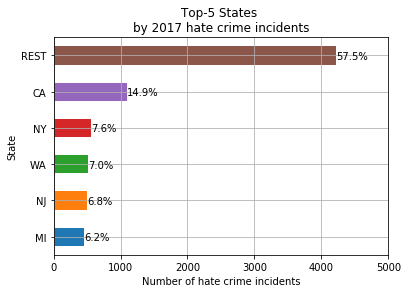

In [404]:
fig0, ax0 = plt.subplots()
ax0 = absolute_rank_2017.plot(kind = 'barh', grid=True, title = "Top-5 States \nby 2017 hate crime incidents")
ax0.set_xlabel("Number of hate crime incidents")
ax0.set_ylabel("State")
ax0.set_xlim(0,5000)


individuals =[]
for i in ax0.patches:
    individuals.append(i.get_width())
    
total = sum(individuals)

for i in ax0.patches:
    ax0.text(i.get_width()+.3, i.get_y()+.15, \
            str(round((i.get_width()/total)*100,1))+'%')

#ax0.invert_yaxis()

fig0.savefig(output_file_path / "fig1.1(top5_states_2017_abs).png")
ax0.get_xlim()

### *<font color=green> Plot1.2: State ranking basis 10 year average of Hate Crime incidents *</font>

In [405]:
absolute_rank_10yr = df_results.pivot_table(index = 'STATE_ABBR', values = 'HATE_CRIMES', aggfunc = np.sum)
series_abs_10Y = absolute_rank_10yr['HATE_CRIMES'].nlargest(5)
REST = absolute_rank_10yr['HATE_CRIMES'].nsmallest(45).sum()

series_abs_10Y.loc['REST'] = REST
series_abs_10Y =series_abs_10Y/10
series_abs_10Y.sort_values(inplace = True)
series_abs_10Y

STATE_ABBR
MA       359.3
MI       403.3
NJ       471.0
NY       601.9
CA       990.5
REST    3355.5
Name: HATE_CRIMES, dtype: float64

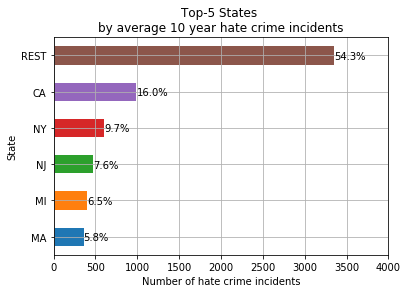

In [406]:
fig1, ax1 = plt.subplots()
ax1 = series_abs_10Y.plot(kind = 'barh', grid=True, title = "Top-5 States \nby average 10 year hate crime incidents")
ax1.set_xlabel("Number of hate crime incidents")
ax1.set_ylabel("State")
ax1.set_xlim(0,4000)


individuals =[]
for i in ax1.patches:
    individuals.append(i.get_width())
    
total = sum(individuals)

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.15, \
            str(round((i.get_width()/total)*100,1))+'%')

fig1.savefig(output_file_path / "fig1.2(top5_states_10yr_avg).png")


### *<font color=green> Plot1.3: State ranking basis  2017 hate incidents per 100K population *</font>

In [407]:
temp = df_results.set_index('STATE_ABBR')
per_100k_rank_2017 = temp.loc[temp['DATA_YEAR'] == 2017,:]
# per_100k_rank_2017['HATE_CRIMES_100K'].nlargest(5)

# getting data for rest of the states to categorize under 'REST'
hate_crimes_5 = per_100k_rank_2017['HATE_CRIMES'].nlargest(5).sum()
hate_crimes_rest = per_100k_rank_2017['HATE_CRIMES'].nsmallest(45).sum()

top_5_list = per_100k_rank_2017['HATE_CRIMES_100K'].nlargest(5).index.tolist()

pop_5 = per_100k_rank_2017.loc[top_5_list,'STATE_POPULATION'].sum()
pop_rest = per_100k_rank_2017.loc[:, 'STATE_POPULATION'].sum() - pop_5
pop = per_100k_rank_2017['STATE_POPULATION'].sum()

REST = hate_crimes_rest/(pop_rest/100000)


# Adding REST of states category data 
per_100k_rank_2017 = per_100k_rank_2017['HATE_CRIMES_100K'].nlargest(5)
per_100k_rank_2017.loc['REST'] = REST
per_100k_rank_2017 = round (per_100k_rank_2017,2)
per_100k_rank_2017.sort_values(inplace = True)

print (hate_crimes_5, hate_crimes_rest)
print (pop_5, pop_rest)

3115 4219
28419367.0 295872273.0


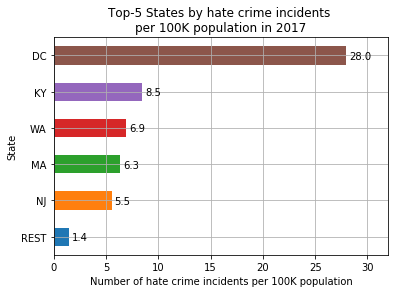

In [408]:
fig2, ax2 = plt.subplots()
ax2 =per_100k_rank_2017.plot(kind = 'barh', grid=True, title = "Top-5 States by hate crime incidents \nper 100K population in 2017")
ax2.set_xlabel("Number of hate crime incidents per 100K population")
ax2.set_ylabel("State")
ax2.set_xlim(0,32)

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.15, str(round(i.get_width(),1)))

fig2.savefig(output_file_path / "fig1.3(hate_crime_2017_per100K_population).png")

### *<font color=green> Plot1.4: State ranking basis 10 year average of  Hate Crime incidents per 100K population *</font>

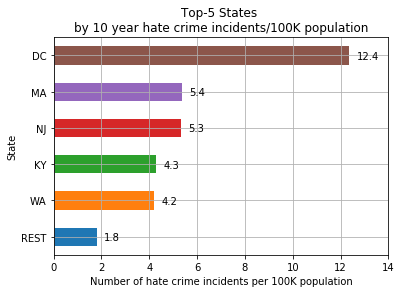

In [409]:
per100k_rank_10yr = df_results.pivot_table(index = 'STATE_ABBR', values = 'HATE_CRIMES_100K', aggfunc = np.mean)
series_per100k_10Y = per100k_rank_10yr['HATE_CRIMES_100K'].nlargest(5)
#REST = per100k_rank_10yr['HATE_CRIMES_100K'].nsmallest(45).mean()

templist = series_per100k_10Y.index.tolist()
tempdf = df_results.pivot_table(index = 'STATE_ABBR', values = ['HATE_CRIMES', 'STATE_POPULATION'], aggfunc = np.sum)
tempdf.drop(templist, axis = 0, inplace = True)

REST = tempdf['HATE_CRIMES'].sum()/(tempdf['STATE_POPULATION'].sum()/100000)
series_per100k_10Y.loc['REST'] = REST
series_per100k_10Y.sort_values(inplace = True)

fig3, ax3 = plt.subplots()
ax3 =series_per100k_10Y.plot(kind = 'barh', grid=True, title = "Top-5 States \nby 10 year hate crime incidents/100K population")
ax3.set_xlabel("Number of hate crime incidents per 100K population")
ax3.set_ylabel("State")
ax3.set_xlim(0,14)

for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.15, str(round(i.get_width(),1)))


fig3.savefig(output_file_path / "fig1.4(top5_states_10yr_per100k).png")

### *<font color=green> Plot1.5: Hate crimes per 100K population- 3 year Moving averages of top5 3YMA states in 2017 *</font>


In [410]:
temp1 = df_results.pivot_table(index ='DATA_YEAR', values = 'HATE_CRIMES_100K', columns = 'STATE_ABBR')
temp1.head(10)

STATE_ABBR,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
DATA_YEAR,,,,,,,,,,,,,,,,,,,,,
2008,1.165683,0.235955,3.221977,2.846075,3.759862,3.320204,5.112457,7.096597,7.101199,0.834773,...,5.471317,4.344407,1.015334,1.461762,3.436696,3.541133,3.664556,1.687999,2.535178,1.126405
2009,1.288525,0.191135,2.595650,3.320306,2.754205,4.139511,5.684583,6.170194,4.180215,0.701263,...,5.169975,2.715901,0.665798,1.759696,1.902928,3.860010,3.121157,0.954945,1.373795,1.469859
2010,0.980192,0.397041,2.156362,3.679934,2.924619,3.050899,4.111315,9.422858,2.222736,0.721922,...,6.245423,2.312253,0.689014,2.269878,2.180970,2.716050,3.440631,1.633970,1.779582,0.354262
2011,1.105186,1.727839,1.225081,2.984237,2.759797,3.635438,3.959052,13.408291,1.761849,0.644578,...,2.671222,2.312577,0.596915,2.451723,1.813833,1.436341,3.121672,1.383576,1.024310,0.352512
2012,0.821572,0.124545,1.728914,2.686552,2.394745,3.641999,4.148378,11.366740,1.090450,0.745313,...,3.596920,4.972955,0.671507,3.572841,1.685676,2.236590,3.973711,1.205334,1.454209,0.346845
2013,1.085100,0.124121,0.912543,3.029391,2.190917,2.446849,4.000732,11.092094,1.405041,0.607133,...,2.483708,3.155172,0.535735,2.618174,1.487241,2.073845,4.215814,0.870632,3.129055,0.171461
2014,0.814060,0.185704,0.337060,3.938305,1.956574,1.755176,3.477282,10.608697,1.388936,0.326542,...,2.109448,3.023926,0.585639,1.867891,1.476928,2.393234,4.304019,0.902867,1.568627,NaN
2015,1.084438,0.206021,0.167906,4.048366,2.146487,1.963728,2.594338,9.696037,1.165160,0.355645,...,1.864978,3.350995,0.696327,1.571574,1.888239,1.277776,3.840627,0.745506,2.226986,0.340974
2016,1.483435,0.288034,0.401575,3.140994,2.369169,1.898698,3.010298,16.804611,1.574476,0.532518,...,2.089277,2.240802,0.641465,2.200819,1.509321,4.010562,5.425128,0.675568,2.242107,0.512899


In [411]:
# Creating another dataframe with 3 year moving averages
temp2 = temp1.rolling(window =3).mean()

In [412]:
temp2.head()

STATE_ABBR,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
DATA_YEAR,,,,,,,,,,,,,,,,,,,,,
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,1.144800,0.274710,2.657996,3.282105,3.146229,3.503538,4.969452,7.563216,4.501383,0.752653,...,5.628905,3.124187,0.790049,1.830445,2.506865,3.372398,3.408781,1.425638,1.896185,0.983509
2011,1.124634,0.772005,1.992364,3.328159,2.812874,3.608616,4.584984,9.667114,2.721600,0.689254,...,4.695540,2.446910,0.650576,2.160433,1.965910,2.670800,3.227820,1.324164,1.392562,0.725544
2012,0.968983,0.749808,1.703452,3.116908,2.693053,3.442779,4.072915,11.399296,1.691678,0.703937,...,4.171188,3.199262,0.652479,2.764814,1.893493,2.129660,3.512004,1.407627,1.419367,0.351207


In [413]:
temp2.T[2017].nlargest(5)

STATE_ABBR
DC    18.151889
MA     6.052944
KY     5.853132
WA     5.388602
NJ     4.125001
Name: 2017, dtype: float64

In [414]:
state_filter_3yMA = temp2.T[2017].nlargest(5).index.tolist()
state_filter_3yMA

['DC', 'MA', 'KY', 'WA', 'NJ']

In [415]:
x = temp2.index.tolist()[2:] # discarding 2008 & 2009 as irrelevant for 3 year MA
y =[]
for state in state_filter_3yMA:
    y.append(temp2[state].tolist()[2:])
y[0]

[7.56321622261741,
 9.667114228491434,
 11.399296232069352,
 11.95570804780918,
 11.022510108716936,
 10.465609020746454,
 12.369781338266074,
 18.151888555477758]

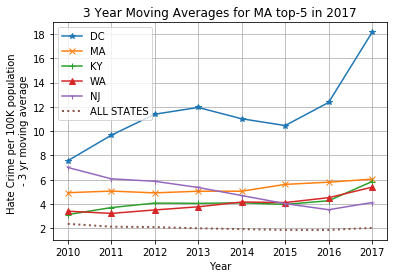

In [416]:
fig4, ax4 = plt.subplots()
markers= ['*', 'x', '+', '^', '1']
for n in range (len(y)):
    ax4.plot(x,y[n], marker= markers[n], label = state_filter_3yMA[n])
    
country = df_results.pivot_table(index ='DATA_YEAR', values = ['HATE_CRIMES', 'STATE_POPULATION'], aggfunc = np.sum)
country['per100K'] = round(country.HATE_CRIMES/(country.STATE_POPULATION/100000),1)
country = country.per100K.rolling(window =3).mean()[2:10]
ax4.plot(x,country , label = 'ALL STATES', linewidth = 2, linestyle = ':')
ax4.legend(loc='best')
ax4.set_xlabel("Year")
ax4.set_ylabel("Hate Crime per 100K population \n - 3 yr moving average")
ax4.set_xticks(x)
ax4.grid(True)
ax4.set_title("3 Year Moving Averages for MA top-5 in 2017")
fig4.savefig(output_file_path/ 'fig1.5(3Y MA of Hate Crime per 100K population for top-5 in 2017 MA).png')

### *<font color=green> Plot1.6: Hate crimes per 100K population- 3 year Moving averages of top- 5 states in 2017 by absolute hate crime incidents *</font>

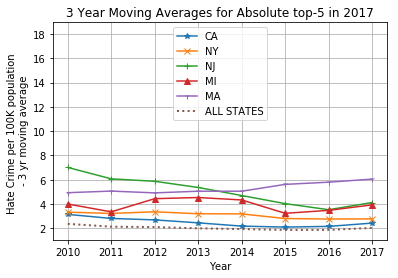

In [428]:
state_filter = absolute_rank_10yr['HATE_CRIMES'].nlargest().index.tolist()
x = temp2.index.tolist()[2:] # discarding 2008 & 2009 as irrelevant for 3 year MA
y1 =[]
for state in state_filter:
    y1.append(temp2[state].tolist()[2:])

    
fig5, ax5 = plt.subplots()
markers= ['*', 'x', '+', '^', '1']
for n in range (len(y1)):
    ax5.plot(x,y1[n], marker= markers[n], label = state_filter[n])
ax5.plot(x,country , label = 'ALL STATES', linewidth = 2, linestyle = ':')
ax5.legend(loc='upper center')
ax5.set_xlabel("Year")
ax5.set_ylabel("Hate Crime per 100K population \n - 3 yr moving average")
ax5.set_xticks(x)
ax5.grid(True)
ax5.set_ylim(ax4.get_ylim()) # setting scales same as previous chart
ax5.set_title("3 Year Moving Averages for Absolute top-5 in 2017")
fig5.savefig(output_file_path/ 'fig1.6(3Y MA of Hate Crime per 100K population for absolute top-5 in 2017).png')

## Analysis of Hate-crime locations

In [418]:
df_locations = df.pivot_table(index = ['LOCATION'], columns ='DATA_YEAR', values = ['INCIDENT_ID'], aggfunc = np.size)
df_locations


INCIDENT_ID                                \
DATA_YEAR                                 2008  2009  2010  2011  2012  2013   
LOCATION                                                                       
 Others                                   1303  1168  1209   956  1084  1072   
Educational institution                    936   756   724   585   624   504   
Highway/Road/Alley/Street/Sidewalk        1392  1128  1133  1123  1155  1097   
Parking/Drop Lot/Garage                    482   403   386   368   378   341   
Places of worship                          337   284   244   278   266   214   
Public utility places                      408   298   340   327   350   337   
Recreation places                          334   251   269   328   307   328   
Residence/Home                            2551  2082  2079  2044  2122  1906   
Shopping places                            296   242   244   290   307   245   

                                                            
DATA_YEAR                           2014  2015  2016  2017  
LOCATION                                                    
 Others                              862   911  1073  1217  
Educational institution              484   484   610   778  
Highway/Road/Alley/Street/Sidewalk   997  1025  1155  1229  
Parking/Drop Lot/Garage              350   329   364   430  
Places of worship                    200   260   245   295  
Public utility places                370   387   425   509  
Recreation places                    294   340   366   460  
Residence/Home                      1777  1844  1731  2017  
Shopping places                      263   280   294   399

In [419]:
df_locations_T = df_locations.T
df_locations_T

LOCATION                Others  Educational institution  \
            DATA_YEAR                                     
INCIDENT_ID 2008          1303                      936   
            2009          1168                      756   
            2010          1209                      724   
            2011           956                      585   
            2012          1084                      624   
            2013          1072                      504   
            2014           862                      484   
            2015           911                      484   
            2016          1073                      610   
            2017          1217                      778   

LOCATION               Highway/Road/Alley/Street/Sidewalk  \
            DATA_YEAR                                       
INCIDENT_ID 2008                                     1392   
            2009                                     1128   
            2010                                     1133   
            2011                                     1123   
            2012                                     1155   
            2013                                     1097   
            2014                                      997   
            2015                                     1025   
            2016                                     1155   
            2017                                     1229   

LOCATION               Parking/Drop Lot/Garage  Places of worship  \
            DATA_YEAR                                               
INCIDENT_ID 2008                           482                337   
            2009                           403                284   
            2010                           386                244   
            2011                           368                278   
            2012                           378                266   
            2013                           341                214   
            2014                           350                200   
            2015                           329                260   
            2016                           364                245   
            2017                           430                295   

LOCATION               Public utility places  Recreation places  \
            DATA_YEAR                                             
INCIDENT_ID 2008                         408                334   
            2009                         298                251   
            2010                         340                269   
            2011                         327                328   
            2012                         350                307   
            2013                         337                328   
            2014                         370                294   
            2015                         387                340   
            2016                         425                366   
            2017                         509                460   

LOCATION               Residence/Home  Shopping places  
            DATA_YEAR                                   
INCIDENT_ID 2008                 2551              296  
            2009                 2082              242  
            2010                 2079              244  
            2011                 2044              290  
            2012                 2122              307  
            2013                 1906              245  
            2014                 1777              263  
            2015                 1844              280  
            2016                 1731              294  
            2017                 2017              399

In [420]:
location_filter = df_locations_T.columns.tolist()
location_filter

[' Others',
 'Educational institution',
 'Highway/Road/Alley/Street/Sidewalk',
 'Parking/Drop Lot/Garage',
 'Places of worship',
 'Public utility places',
 'Recreation places',
 'Residence/Home',
 'Shopping places']

### *<font color=green> Plot2.1: Hate crimes locations - 10 year data *</font>

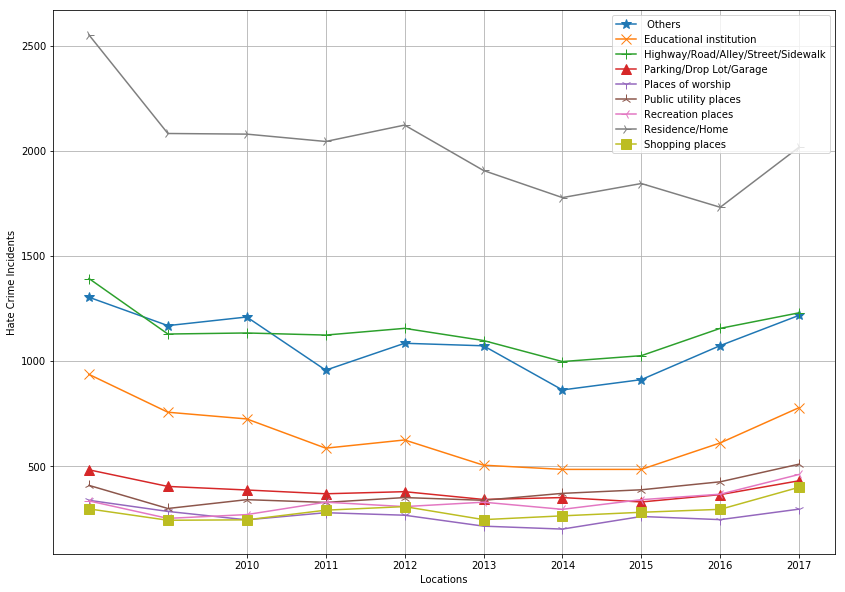

In [421]:
fig6, ax6 = plt.subplots(figsize = (14,10))
markers= ['*', 'x', '+', '^', '1', '2', '3', '4', 's','8']
for n in range (len(location_filter)):
    ax6.plot(df.DATA_YEAR.unique().tolist(),df_locations_T[location_filter[n]].tolist(), marker= markers[n], markersize = 10, label = location_filter[n])
ax6.legend(loc='best')
ax6.set_xlabel("Locations")
ax6.set_ylabel("Hate Crime Incidents")
ax6.set_xticks(x)
ax6.grid(True)
fig6.savefig(output_file_path / "fig1.7(Hate crime locations).png")

# POST submission

Text(0.5, 1.0, 'Population/crimes in localities reporting Hate Crimes \nas % of total Population/crimes ')

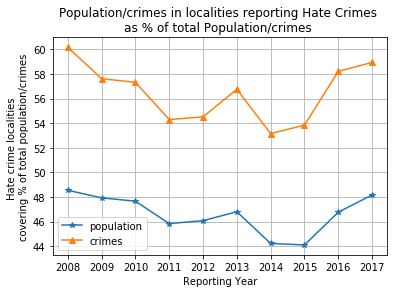

In [422]:
reporting = df_results.pivot_table(index = 'DATA_YEAR', values = ['POPULATION_SAME_AREA','STATE_POPULATION','TOTAL_CRIMES_SAME_AREA','STATE_TOTAL_CRIMES' ], aggfunc = np.mean)
reporting ['POP_Coverage'] = 100*(reporting['POPULATION_SAME_AREA'])/reporting['STATE_POPULATION']
reporting ['CRIME_Coverage'] = 100*(reporting['TOTAL_CRIMES_SAME_AREA'])/reporting['STATE_TOTAL_CRIMES']
reporting.drop(['POPULATION_SAME_AREA','STATE_POPULATION','STATE_TOTAL_CRIMES','TOTAL_CRIMES_SAME_AREA'], axis =1, inplace = True)
reporting
fig7, ax7 = plt.subplots()
ax7.plot(reporting.index, reporting.POP_Coverage, marker = '*', label = 'population')
ax7.plot(reporting.index, reporting.CRIME_Coverage, marker = '^', label = 'crimes')
ax7.set_xticks(reporting.index.tolist())
ax7.grid(True)
ax7.legend(loc= 'best')
ax7.set_xlabel("Reporting Year")
ax7.set_ylabel("Hate crime localities \ncovering % of total population/crimes")
ax7.set_title ("Population/crimes in localities reporting Hate Crimes \nas % of total Population/crimes ")

In [423]:
df_results.head()

,Unnamed: 0,STATE_ABBR,DATA_YEAR,HATE_CRIMES,POPULATION_SAME_AREA,TOTAL_CRIMES_SAME_AREA,STATE_POPULATION,STATE_TOTAL_CRIMES,HATE_CRIMES_100K,HATE_CRIMES_PCT_TOTAL_CRIME
0,0,AK,2008,8,286625.0,24112.0,686293.0,44822.0,1.165683,0.017848
1,1,AK,2009,9,289884.0,26148.0,698473.0,45690.0,1.288525,0.019698
2,2,AK,2010,7,291826.0,25378.0,714146.0,45233.0,0.980192,0.015475
3,3,AK,2011,8,296955.0,23812.0,723860.0,42826.0,1.105186,0.018680
4,4,AK,2012,6,299143.0,26141.0,730307.0,44673.0,0.821572,0.013431


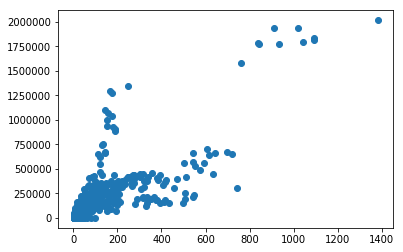

In [424]:
plt.scatter(temps['HATE_CRIMES'], temps['TOTAL_CRIMES_SAME_AREA'])

In [425]:
df_results.drop('Unnamed: 0', axis = 1, inplace = True)
df_results.corr()

,DATA_YEAR,HATE_CRIMES,POPULATION_SAME_AREA,TOTAL_CRIMES_SAME_AREA,STATE_POPULATION,STATE_TOTAL_CRIMES,HATE_CRIMES_100K,HATE_CRIMES_PCT_TOTAL_CRIME
DATA_YEAR,1.000000,-0.028312,0.007277,-0.053718,0.021129,-0.060235,-0.049449,0.023805
HATE_CRIMES,-0.028312,1.000000,0.854722,0.782669,0.730890,0.637120,0.309980,0.398289
POPULATION_SAME_AREA,0.007277,0.854722,1.000000,0.964432,0.927947,0.869879,0.033569,0.063968
TOTAL_CRIMES_SAME_AREA,-0.053718,0.782669,0.964432,1.000000,0.933887,0.935624,0.004252,-0.017509
STATE_POPULATION,0.021129,0.730890,0.927947,0.933887,1.000000,0.963321,-0.110806,-0.088802
STATE_TOTAL_CRIMES,-0.060235,0.637120,0.869879,0.935624,0.963321,1.000000,-0.139447,-0.174555
HATE_CRIMES_100K,-0.049449,0.309980,0.033569,0.004252,-0.110806,-0.139447,1.000000,0.859392
HATE_CRIMES_PCT_TOTAL_CRIME,0.023805,0.398289,0.063968,-0.017509,-0.088802,-0.174555,0.859392,1.000000
